In [1]:
### Package Imports ###
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss
import xgboost as xgb
import shap 
import time
from imblearn.under_sampling import RandomUnderSampler

In [2]:
### Data Import ###
# Original Datasets
train = pd.read_csv('../data/kkbox/train.csv')
members = pd.read_csv('../data/kkbox/members_v3.csv')

# Feature-Engineered Datasets
transaction_features = pd.read_csv('../data/kkbox/transactions_features.csv', index_col=0)
user_logs_features = pd.read_csv('../data/kkbox/user_logs_features_new.csv', index_col=0)

In [3]:
# Pre-processing for Original Datasets
# Members Data
# bd renamed as age 
members = members.rename(columns={'bd': 'age'})

# visualizing age outliers
#members[(members['age'] >= 0) & (members['age'] < 99)]['age'].hist(bins=25)
#plt.title("Recorded age of members")
#plt.show()

#print((len(members[members['age'] < 0]) + len(members[members['age'] > 99])) / len(members))
# members with ages outside of 0-99 can be dropped
members = members[(members['age'] >= 0) & (members['age'] < 99)]
#len(members[members['age'] == 0])
# 4.5mn members (out of 6.7mn total) have age 0 (i.e. using the current date as their birthday), they can not be dropped

# replace NAs in gender
members['gender'] = members['gender'].fillna('not_specified')

# registration_init_time as datetime
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'].astype('str'), format='%Y%m%d')
# convert to days since unix epoch start
members['registration_init_time'] = members['registration_init_time'].astype('int') / (10**9 * 60 * 60 * 24) 
# convert to days since first registration
members['registration_init_time'] = members['registration_init_time'] - min(members['registration_init_time'])

# create categorical columns for city, age, gender and registered_via
members['city'] = members['city'].astype('category')
#members['age'] = members['age'].astype('category')
members['gender'] = members['gender'].astype('category')
members['registered_via'] = members['registered_via'].astype('category')

In [4]:
# Create singular train dataset
data = pd.merge(train, members, on='msno', how='left')
data = pd.merge(data, transaction_features, on='msno', how='left')
data = pd.merge(data, user_logs_features, on='msno', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 41 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   msno                                     992931 non-null  object  
 1   is_churn                                 992931 non-null  int64   
 2   city                                     876620 non-null  category
 3   age                                      876620 non-null  float64 
 4   gender                                   876620 non-null  category
 5   registered_via                           876620 non-null  category
 6   registration_init_time                   876620 non-null  float64 
 7   num_transactions                         992931 non-null  int64   
 8   total_act_pay                            992931 non-null  int64   
 9   mean_act_pay                             992931 non-null  float64 
 10  mean_plan_days      

In [5]:
data

,msno,is_churn,city,age,gender,registered_via,registration_init_time,num_transactions,total_act_pay,mean_act_pay,...,avg_num100_per_num_unq,last_30_avg_sec_per_song,last_60_avg_sec_per_song,last_90_avg_sec_per_song,total_secs_diff_last_30_vs_last_60_avg,total_secs_diff_last_30_vs_last_90_avg,total_secs_diff_last_30_vs_last_180_avg,total_secs_diff_last_60_vs_last_180_avg,total_secs_diff_last_60_vs_last_270_avg,total_secs_diff_last_60_vs_last_365_avg
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36.0,female,9,376.0,2,149,74.500000,...,0.885281,215.816860,215.061884,215.061884,0.881843,1.822764,4.404816,1.872087,3.308130,148.348511
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38.0,male,9,377.0,23,3458,150.347826,...,1.374723,265.638667,160.698716,170.010750,-0.979718,-0.977282,-0.967141,0.620077,-0.007070,171.365221
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27.0,female,9,569.0,10,1492,149.200000,...,0.869938,180.271862,159.070599,155.832100,-0.512163,-0.339436,-0.780567,-0.550191,-0.715363,51.600537
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23.0,female,9,586.0,2,1788,894.000000,...,0.977867,152.067982,146.211114,142.996397,0.281767,0.149079,-0.321826,-0.470907,-0.581641,134.044037
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27.0,male,9,642.0,8,3576,447.000000,...,0.945744,237.024944,242.484727,247.326535,-0.090419,-0.325722,-0.517883,-0.469957,-0.519681,141.573669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992926,tUM0yxAj50Vc35vQZ++xMlomdyeLJUW9lEcoPnt3H+g=,0,12,24.0,male,4,4695.0,2,298,149.000000,...,0.852700,176.573957,176.573957,176.573957,1.000000,2.000000,5.000000,2.000000,3.500000,167.000000
992927,KQS8etmfGgvE/7Y9gK+E9wdLnRTI0lyyPXaXL3I8E4c=,0,15,17.0,female,4,4704.0,1,0,0.000000,...,0.444444,135.769604,135.769604,135.769604,1.000000,2.000000,5.000000,2.000000,3.500000,29.000000
992928,8/jDLgNREuWI9hcKVYp8723nmavn01T+AuMWkK3uM7g=,0,NaN,NaN,NaN,NaN,NaN,2,200,100.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992929,iNV99F1Rml7EMndOeLI0Y/iek6aCj/Qp1Z4dZvR+sak=,0,1,0.0,not_specified,7,4709.0,2,200,100.000000,...,0.692771,170.407770,170.407770,170.407770,1.000000,2.000000,5.000000,2.000000,3.500000,53.000000


In [6]:
### XGBoost Algorithm ###
# Time-Logging
start_time = time.time()

# Splitting the data into train and test sets
X = data.drop(['msno','is_churn'], axis=1)  # Features
y = data['is_churn']  # Target variable

# Drop categorical features
X = X.drop(['city', 'registered_via'], axis=1)

# Random under sampling to balance the dataset
rus = RandomUnderSampler(random_state=42, replacement=False)
X, y = rus.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Random under sampling (the training set) to balance the dataset
# rus = RandomUnderSampler(random_state=42, replacement=False)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# Perform one-hot encoding for categorical features
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# Define XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for XGBoost
param_grid = {
    #'n_estimators': [100],
    #'max_depth': [3],
    #'learning_rate': [0.1]
    'n_estimators': [300],
    'max_depth': [10],
    'learning_rate': [0.01],
    #'subsample': [0.5, 0.75, 1],
    #'colsample_bytree': [0.5, 0.75, 1]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='recall')
grid_search.fit(X_train_encoded, y_train)

#print(grid_search.cv_results_)
print(f'Best parameters: {grid_search.best_params_}')

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)

# Time-Logging
end_time = time.time()
print(f'Total training time: {(end_time - start_time)/60} minutes')

# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(classification_report(y_test, y_pred))
print(f"Confusion matrix: TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp} \n", conf_mat)
print(f'AUC score: {round(roc_auc_score(y_test, y_pred),2)}')
print(f'Log-loss: {round(log_loss(y_test, y_pred),2)}')

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
Total training time: 0.2916016459465027 minutes
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     12795
           1       0.92      0.96      0.94     12594

    accuracy                           0.94     25389
   macro avg       0.94      0.94      0.94     25389
weighted avg       0.94      0.94      0.94     25389

Confusion matrix: TN: 11695, FP: 1100, FN: 471, TP: 12123 
 [[11695  1100]
 [  471 12123]]
AUC score: 0.94
Log-loss: 2.23


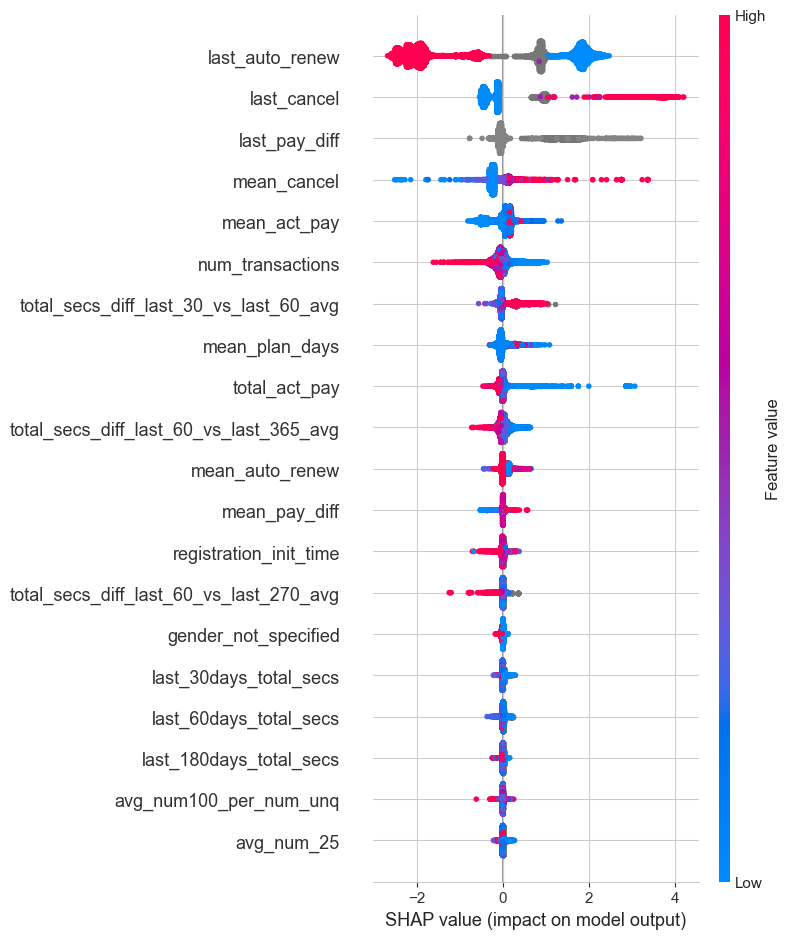

In [7]:
### Model Explanation using Shapley Values ###
# Initialize an explainer with the best model's predict method
explainer = shap.Explainer(best_model)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_encoded)

In [8]:
def shapley_feature_ranking(shap_values, X):
    feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
    return pd.DataFrame(
        {
            "features": [X.columns[i] for i in feature_order][::-1],
            "importance": [
                              np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
                          ][::-1],
        }
    )


feature_ranking = shapley_feature_ranking(shap_values, X_test_encoded)
feature_ranking['normalized_importance'] = feature_ranking['importance'] / sum(feature_ranking['importance'])
feature_ranking

,features,importance,normalized_importance
0,last_auto_renew,1.760251,0.448778
1,last_cancel,0.606388,0.154599
2,last_pay_diff,0.246963,0.062964
3,mean_cancel,0.215093,0.054838
4,mean_act_pay,0.179069,0.045654
5,num_transactions,0.138290,0.035257
6,total_secs_diff_last_30_vs_last_60_avg,0.119145,0.030376
7,mean_plan_days,0.098595,0.025137
8,total_act_pay,0.088124,0.022467
9,total_secs_diff_last_60_vs_last_365_avg,0.083162,0.021202


In [13]:
columns_to_drop = feature_ranking[feature_ranking["normalized_importance"] < 0.05]['features'].tolist()
print(columns_to_drop)

['mean_act_pay', 'num_transactions', 'total_secs_diff_last_30_vs_last_60_avg', 'mean_plan_days', 'total_act_pay', 'total_secs_diff_last_60_vs_last_365_avg', 'mean_auto_renew', 'mean_pay_diff', 'registration_init_time', 'total_secs_diff_last_60_vs_last_270_avg', 'gender_not_specified', 'last_30days_total_secs', 'last_60days_total_secs', 'last_180days_total_secs', 'avg_num100_per_num_unq', 'avg_num_25', 'last_90days_total_secs', 'last_270days_total_secs', 'age', 'total_secs_diff_last_60_vs_last_180_avg', 'all_time_total_secs', 'avg_num50_per_num_unq', 'avg_num_50', 'last_365days_total_secs', 'last_30_avg_sec_per_song', 'total_secs_diff_last_30_vs_last_180_avg', 'total_secs_diff_last_30_vs_last_90_avg', 'avg_num985_per_num_unq', 'last_90_avg_sec_per_song', 'avg_num_75', 'last_60_avg_sec_per_song', 'avg_num25_per_num_unq', 'avg_num75_per_num_unq', 'gender_female', 'gender_male']


In [14]:
# Original train and test set
X = data.drop(['msno','is_churn'], axis=1)  # Features
y = data['is_churn']  # Target variable

# Drop categorical features
X = X.drop(['city', 'registered_via'], axis=1)

# Random under sampling to balance the dataset
rus = RandomUnderSampler(random_state=42, replacement=False)
X, y = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Random under sampling (the training set) to balance the dataset
# rus = RandomUnderSampler(random_state=42, replacement=False)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# Perform one-hot encoding for categorical features
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# Drop non-important features from X_train and X_test
X_train_encoded = X_train_encoded.drop(columns=columns_to_drop)
X_test_encoded = X_test_encoded.drop(columns=columns_to_drop)

In [15]:
X_train_encoded

,last_pay_diff,last_auto_renew,mean_cancel,last_cancel
42326,0.0,0.0,0.000000,0.0
732435,0.0,1.0,0.000000,0.0
36734,NaN,NaN,0.142857,NaN
79816,0.0,1.0,0.000000,0.0
43257,0.0,0.0,0.000000,0.0
...,...,...,...,...
56408,0.0,1.0,0.083333,1.0
40223,0.0,0.0,0.000000,0.0
885592,0.0,1.0,0.000000,0.0
789499,0.0,1.0,0.074074,0.0


In [17]:
### XGBoost Algorithm with Important Features Only ### 
# Time-Logging
start_time = time.time()

# Define XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for XGBoost
param_grid = {
    #'n_estimators': [100],
    #'max_depth': [3],
    #'learning_rate': [0.1]
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.5, 0.75]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='recall')
grid_search.fit(X_train_encoded, y_train)

#print(grid_search.cv_results_)
print(f'Best parameters: {grid_search.best_params_}')

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)

# Time-Logging
end_time = time.time()
print(f'Total training time: {(end_time - start_time)/60} minutes')

# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(classification_report(y_test, y_pred))
print(f"Confusion matrix: TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp} \n", conf_mat)
print(f'AUC score: {round(roc_auc_score(y_test, y_pred),2)}')
print(f'Log-loss: {round(log_loss(y_test, y_pred),2)}')

Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
Total training time: 0.5467069824536641 minutes
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     12795
           1       0.92      0.96      0.94     12594

    accuracy                           0.94     25389
   macro avg       0.94      0.94      0.94     25389
weighted avg       0.94      0.94      0.94     25389

Confusion matrix: TN: 11678, FP: 1117, FN: 531, TP: 12063 
 [[11678  1117]
 [  531 12063]]
AUC score: 0.94
Log-loss: 2.34
